# 1.1) Source Code

In [1]:
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 데이터 준비

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
36322,Woman assaulted by drunk men for going out wit...,A group of drunk men allegedly assaulted a wom...
74617,K'taka govt to rename 100 Morarji Desai school...,The Karnataka government has decided to rename...
14938,Raise age to report rape by minor victims to 3...,Women and Child Development Minister Maneka Ga...
74321,Maneka Gandhi calls for rehabilitation-focusse...,Union Minister Maneka Gandhi has expressed the...
61421,"China to build police station powered by AI, n...",The Chinese government has announced that it w...
29524,"United Breweries profit up 1,250% to Ã¢ÂÂ¹91 ...",United Breweries Limited (UBL) has reported ab...
91957,Reliance reports 45% rise in revenue for March...,Mukesh Ambani-led Reliance Industries posted a...
38776,Ronda Rousey to be the first female Hall of Fa...,American fighter Ronda Rousey will become the ...
89238,I've kissed Javier Bardem and his wife Penelop...,Johnny Depp jokingly said that he has kissed a...
35889,Jammu bar body chief threatened me: Kathua vic...,The lawyer representing the eight-year-old Kat...


- News 데이터와 헤드라인을 불러와 sample 을 확인합니다.

In [4]:
print('전체 샘플수 :', len(data))

전체 샘플수 : 98401


### 데이터 전처리

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- Text 에서 중복을 제외한다면, 98360 개
- Headlines 에서 중복을 제외한다면, 98280 개

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98360


- text 열에서 중복을 제거합니다.
- headlines 는 해당 기사에 대한 요약이므로 중복될 수 있습니다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 데이터에 null 값이 존재하는지 확인합니다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 텍스트 정규화를 위한 사전을 구성하였습니다.
- 같은 의미를 가진 다른 표현들을 하나의 단어로 간주할 수 있도록 하기 위함입니다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 불용어 처리를 위해 NLTK 에서 제공하는 불용어 리스트를 참조합니다.

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- 데이터 전처리를 자동화하는 함수를 정의하였습니다.
- 문장을 영문 소문자로 변환 뒤, lxml parser 로 파싱(parsing) 해줍니다.
- 괄호로 닫힌 내용들을 삭제합니다.
- 큰 따옴표를 제거합니다.
- 앞서 정의한 사전을 활용하여 텍스트를 정규화합니다.
- 소유격을 제거합니다.
- 알파벳 이외의 문자를 공백으로 변환합니다.

- 불용어 처리의 경우에는 text 열에만 적용해주도록 하겠습니다.
- headlines 는 이미 문장의 길이가 짧으며,
- 추상적 요약 시, 자연스러운 문장을 반환하기 위해서는 불용어들이 필요하다고 판단하였습니다.

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_headlines, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


- 함수가 정상적으로 작동하는지 확인해주었습니다.

In [12]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


-  text 와 headlines 에 대한 문장 전처리 작업을 수행하였습니다.
- headlines 에서는 불용어 제거를 수행하지 않았습니다.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

- 전처리가 끝난 문장들을 다시 데이터프레임에 저장해주었습니다.
- 전처리 과정에서 빈 값을 가진 데이터가 생겼을 가능성이 있습니다.
- 따라서, 빈 값을 NaN 으로 대체하여주었습니다.

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- null 값의 개수를 조회합니다.

text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


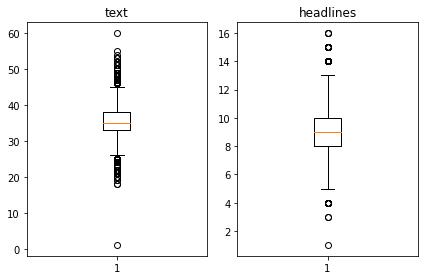

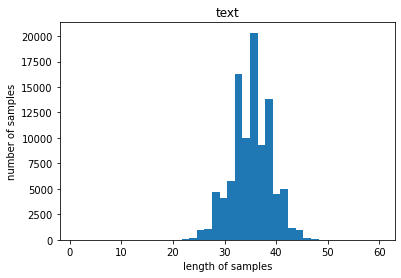

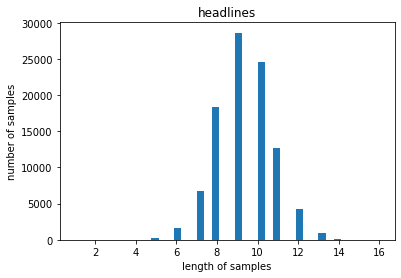

In [16]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text 와 headlines 의 최대 길이를 설정하기 위해 각 컬럼의 문장 길이 분포를 시각화하였습니다.
- text 와 headlines 의 평균 길이는 각각 35, 9 인 것을 알 수 있습니다.
- 아래 그래프에서 text 는 대체적으로 44 이하, headlines 는 12 이하의 문장 길이를 가지고 있음을 확인할 수 있습니다.

In [17]:
text_max_len = 40
headlines_max_len = 10

- 따라서, text 는 40, headlines 는 10 로 최대 길이를 설정하였습니다.
- 밑에서는 위에서 설정한 최대 길이가 적절한지 통계로 확인해보겠습니다.

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len, (cnt / len(nested_list))))

- 최대 길이 내 데이터의 비율을 출력하는 함수를 정의하였습니다.

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


- 각각 40, 10 으로 최대 길이를 설정하였을 경우, 92%, 81% 의 데이터들을 온전히 사용할 수 있습니다.

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', len(data))

전체 샘플수 : 74102


- text 열에서 길이가 40 이하인 데이터를 제외하고 삭제해주었습니다.
- headlines 열에서는 길이가 10 이하인 데이터를 제외하고 삭제해주었습니다.
- 전체 데이터 수는 74102 개가 되었습니다.

- seq2seq 의 training 시에는 decoder의 input과 target 을 모두 지정해주어야합니다.
- 따라서, decoder 의 input 앞에는 'sostoken',
- decoder 의 target 뒤에는 'eostoken' 을 추가해주도록 하겠습니다.
- headlines 열을 사용하여야합니다.

In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [22]:
data.loc[2, 'decoder_target']

'new zealand end rohit sharma led india match winning streak eostoken'

- data 의 앞뒤로 sostoken 과 eostoken 이 잘 붙어있습니다.

In [23]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

- encoder 의 입력값, decoder 의 입력값, decoder 의 target 을 ndarray type 으로 변환하여 주었습니다.

- 이제 준비된 dataset 을 train data 와 test data 로 분리하여 주겠습니다.

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print(indices)

[48372 14135 63036 ...  2999 10969 46217]


- 데이터를 shuffling 하기 위해 random 한 정수 시퀀스를 생성해주었습니다.

In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 정수 시퀀스를 활용하여 데이터를 shuffling 해주었습니다.

In [26]:
n_of_val = int(len(encoder_input) * 0.2)
print("test data 개수: ", n_of_val)

test data 개수:  14820


- 8:2 의 비율로 dataset 을 분리하도록 하겠습니다.
- 따라서, test data 의 수는 14820 개입니다.

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


- train data 의 개수는 59282,
- test data 의 개수는 14820 으로 분리되었습니다.

In [28]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

- encoder_input data 를 정수 인코딩한 후, model 에 입력해주어야 합니다.
- keras 의 tokenizer 를 활용하여 encoder_input_train data 를 토큰화하고,
- 단어집합(vocabulary) 를 생성합니다.

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {}'.format(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {}".format((rare_freq / total_freq) * 100))

단어 집합(vocabulary)의 크기: 61442
등장 빈도가 6번 이하인 희귀 단어의 수: 42106
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 19336
단어 집합에서 희귀 단어의 비율: 68.52967025812961
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.181271223581247


- 생성된 vocabulary 에서 빈도수가 낮은 단어는 제외하고 사용하도록 하겠습니다.
- total_cnt 는 단어의 총 개수입니다.
- rare_cnt 는 threshold 보다 낮은 등장 빈도수를 가지는 단어의 총 개수입니다.
- total_freq 는 단어의 빈도수 총합입니다.
- rare_freq 는 threshold 보다 낮은 등장 빈도수를 가지는 단어의 빈도수 총합입니다.
- tokenizer 의 word_counts 에는 각 단어와 단어의 빈도수가 저장되어 있습니다.

- encoder_input_train 에는 61526 개의 단어가 있습니다.
- 그 중, 6번 이하의 등장 빈도를 가지는 단어는 42220 개로 단어집합에서 68%의 비율을 차지하고 있습니다.
- 그러나, 실제로 6번 이하의 등장 빈도를 가지는 희귀 단어가 등장한 실제 빈도는 4.18% 밖에 되지 않습니다.
- 따라서, 등장 빈도가 6번 이하인 단어들은 정수 인코딩에서 제외하여 training 시 사용하지 않도록 하겠습니다.

In [30]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

- 희귀 단어를 제외한 단어 집합의 크기를 약 19000으로 잡았습니다.
- 단어장의 크기를 19000으로 설정하고 다시 단어집합을 생성해줍니다.

In [31]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[11735, 2140, 3306, 41, 4469, 7953, 90, 15096, 553, 7953, 234, 608, 984, 3836, 1571, 2847, 2123, 3875, 8102, 5017, 6047, 2140, 1133, 4243, 2847, 2123, 6744, 6514, 579, 1436, 1463, 2140, 1027, 1410], [40, 612, 6871, 11736, 1, 76, 146, 71, 85, 371, 219, 18, 627, 4892, 8, 60, 7954, 38, 76, 71, 436, 9252, 3527, 1163, 375, 28, 7817, 711, 76, 71, 1019, 9, 1028, 2479, 6408, 15920, 9759, 4, 11736], [12, 1536, 9760, 6199, 1995, 131, 818, 825, 223, 77, 324, 832, 335, 1591, 3, 323, 250, 1976, 4557, 323, 446, 1692, 1977, 6199, 380, 2808, 12, 1425, 3257, 131, 818, 782, 3410, 32, 1960, 1186, 1001, 3281, 197]]


- 앞서 생성한 단어장을 활용하여 encoder_input data 를 정수인코딩해주었습니다.
- 각 문장의 token 들이 단어장의 index 를 기반으로 int type 으로 변환되었습니다.

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- encoder_input data 는 단어장이 생성되었고, 정수 인코딩도 완료되었습니다.
- decoder_input data 도 마찬가지로 단어장 생성 및 정수 인코딩을 수행하겠습니다.

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {}'.format(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {}".format((rare_freq / total_freq) * 100))

단어 집합(vocabulary)의 크기: 27293
등장 빈도가 5번 이하인 희귀 단어의 수: 18257
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 9036
단어 집합에서 희귀 단어의 비율: 66.89260982669549
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.00597353107781


- decoder_input_train 은 총 27325 개의 단어로 구성되어 있습니다.
- 이 중 등장 빈도가 5번 이하인 희귀 단어는 18240 개로 전체 단어 중 66% 의 비율을 차지하고 있습니다.
- 그러나, 실제로 희귀 단어가 등장하는 빈도는 전체 빈도 중 약 6% 에 불과합니다.
- 따라서, 등장 빈도 5번 이하인 단어들에 대해서만 단어장을 생성하여 training 시 반영하도록 하겠습니다.

In [34]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

- decoder_input_train 과 decoder_target_train을 토큰화하고 9000 개 크기의 단어장을 생성해주었습니다.

In [35]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

- decoder_input_train, test 와 decoder_target_train, test 를 앞서 생성한 단어장을 활용하여 정수 인코딩 해주었습니다.

In [36]:
print('input')
print('decoder ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
decoder  [[1, 50, 8201, 18, 1177, 4, 8202], [1, 28, 42, 326, 16, 408, 299, 5408, 4, 6504, 178], [1, 8, 339, 425, 1758, 3969, 416, 5736, 15, 4142], [1, 632, 135, 26, 160, 9, 2136, 2396, 43, 4, 240], [1, 307, 310, 806, 259, 1096, 159, 492]]
target
decoder  [[50, 8201, 18, 1177, 4, 8202, 2], [28, 42, 326, 16, 408, 299, 5408, 4, 6504, 178, 2], [8, 339, 425, 1758, 3969, 416, 5736, 15, 4142, 2], [632, 135, 26, 160, 9, 2136, 2396, 43, 4, 240, 2], [307, 310, 806, 259, 1096, 159, 492, 2]]


- decoder 의 input 과 target 이 정상적으로 정수 인코딩되었습니다.

- 단어장을 생성하고 정수 인코딩을 수행하는 과정에서 빈도수가 낮은 단어들로만 이루어진 문장의 경우에는 삭제되었을 확률이 높습니다.
- 특히나, text 열로 이루어진 encoder_input data 의 경우에는 확률이 낮지만,
- headlines 열로 이루어진 decoder_input, decoder_target data 의 경우에는 모든 토큰이 삭제되었을 확률이 높습니다.
- 따라서, 모든 문장이 삭제된 data 를 찾아보겠습니다.

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


- 모든 decoder_input 에는 앞서 sostoken 을 추가해주었고,
- 모든 decoder_target 에는 eostoken 을 추가해주었으므로,
- 빈도수가 낮아 모든 토큰이 삭제되었다고 하더라도 sostoken 과 eostoken 은 남아있을 것입니다.
- 따라서, 문장의 길이가 1 인 데이터를 찾아보았습니다.
- 다행히, 모든 토큰이 제거된 문장은 없습니다.

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding = 'post')

- 이제 모든 data 가 정수 인코딩 되었으므로, 패딩을 추가해주었습니다.
- pad_sequences() 를 이용하면 손쉽게 원하는 위치에 패딩을 추가해줄 수 있습니다.
- 앞서 설정한 max_len 을 기준으로 문장의 뒤에 숫자 0 을 추가하였습니다.

### 모델링

In [39]:
# Encoder
embedding_dim = 200
hidden_size = 128

# Encoder Input
encoder_inputs = Input(shape=(text_max_len,))

# Encoder Embedding Layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# Encoder LSTM Layer_1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM Layer_2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM Layer_3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

- Encoder 를 모델링해주었습니다.
- 임베딩 차원 수는 200 으로 설정해주었고, hidden state 의 크기는 128 로 설정하였습니다.
- hidden state 는 LSTM Layer 에서 뉴런의 개수를 의미합니다.
- 또한, Encoder 는 총 3 개의 LSTM Layer 로 구성해주었습니다.
- 모델의 과적합을 최대한 줄여주기 위해 dropout 과 recurrent dropout 을 사용하였습니다.
- 일반적인 dropout 은 Layer 의 weight 을 랜덤으로 생략해주지만, recurrent dropout 을 함께 사용하면, time step 마다 입력을 랜덤으로 생략할 수 있습니다.
- 이제 Encoder 에서 3 개의 층을 통과한 출력 벡터를 Decoder 로 전달해주어야 합니다.

In [40]:
# Decoder Input
decoder_inputs = Input(shape=(None,))

# Decoder Embedding Layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM Layer_1
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True,
                    dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- Decoder 를 모델링해주었습니다.
- Decoder 에서는 LSTM Layer 1 개를 사용하였습니다.
- Encoder 의 hidden_state 와 cell_state 를 Decoder 의 LSTM Layer 생성 시, 파라미터로 넣어주어야 합니다.
- 이제 Attention Layer 를 결합한 Decoder 의 출력층을 설계해보겠습니다.

In [41]:
# Attention Layer
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# Concatenate attn_out and decoder_outputs
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

- Attention Layer 를 설계하였습니다.
- tensorflow 에서는 Attention Function 을 API 로 제공하고 있습니다.
- Encoder output 과 Decoder output 을 Attention Layer 로 전달하여 출력을 반환합니다.
- 이후, Concat Layer 에서 Attention Layer 의 출력값과 Decoder 의 hidden_state 들을 연결합니다.

In [42]:
# Decoder Output Layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

- Decoder 의 Output Layer 에서는 tar_vocab 내의 단어들 중 다음에 나올 단어들의 각 확률을 반환하는 Softmax 활성화함수를 사용하고 있습니다.

In [43]:
# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 200)      3800000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 128), (N 168448      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 즉, Encoder 의 hidden_state 와 Decoder 의 hidden_state 들을 Attention Layer 의 Input 으로하여 리턴한 값을 예측 시에 Decoder 의 hidden_state 와 결합하여 활용하는 형태입니다. 

### 훈련

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 140s 536ms/step - loss: 6.3804 - val_loss: 5.9845
Epoch 2/50
232/232 [==============================] - 124s 533ms/step - loss: 5.8841 - val_loss: 5.6874
Epoch 3/50
232/232 [==============================] - 123s 532ms/step - loss: 5.5846 - val_loss: 5.4465
Epoch 4/50
232/232 [==============================] - 124s 534ms/step - loss: 5.3290 - val_loss: 5.2229
Epoch 5/50
232/232 [==============================] - 124s 533ms/step - loss: 5.1231 - val_loss: 5.0700
Epoch 6/50
232/232 [==============================] - 124s 536ms/step - loss: 4.9565 - val_loss: 4.9593
Epoch 7/50
232/232 [==============================] - 123s 531ms/step - loss: 4.8122 - val_loss: 4.8598
Epoch 8/50
232/232 [==============================] - 124s 537ms/step - loss: 4.6797 - val_loss: 4.7643
Epoch 9/50
232/232 [==============================] - 124s 535ms/step - loss: 4.5636 - val_loss: 4.6971
Epoch 10/50
232/232 [==============================] - 123s 532m

- early stopping 은 검증 데이터의 loss 가 증가하는 현상이 2회 관측될 경우, 학습을 중단하도록 설정되어 있습니다.
- 훈련 데이터의 loss 와 검증 데이터의 loss 를 시각화하겠습니다.

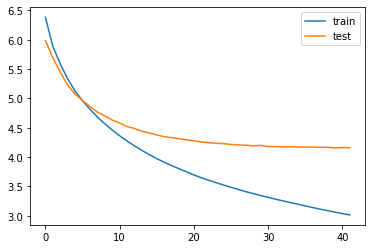

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 테스트

- 학습이 종료되었으므로, 훈련된 모델을 테스트해보도록 하겠습니다.

In [46]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

- 테스트 시에는 정수 인코딩된 데이터들을 실제 문장 데이터로 복원해주어야 합니다.
- 따라서, 3 개의 사전을 준비해두겠습니다.

- 테스트 시 사용할 모델은 훈련 시 설계했던 모델과 달라 별도로 구현해주어야 합니다.
- 훈련 시 설계했던 모델은 decoder 의 Input 에 정답이 되는 target data 를 같이 넣어주어 출력과 한 번에 비교할 수 있었지만,
- 실제 테스트 시에는 정답이 되는 문장이 없으므로, 생성해내야할 문장의 길이만큼 Decoder 가 반복적으로 동작하여야 하기 때문입니다.

In [47]:
# Encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# state Tensor
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- decoder_state_input_h 와 decoder_state_input_c 는 이전 시점의 hidden_state 와 cell_state 를 저장하는 텐서입니다.
- 문장의 다음 단어를 예측하기 위해서 initial_state 를 이전 시점의 hidden_state 와 cell_state 로 설정합니다.
- 훈련 시와는 달리 LSTM Layer 가 리턴하는 hidden_state 와 cell_state 를 계속 활용합니다.

In [48]:
# Attention Function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Decoder Output Layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- Attention Layer 를 설계해주었습니다.
- Attention Layer 의 Output 과 Decoder 의 Output 을 결합하여 결과값을 리턴합니다.
- Decoder 의 최종 Output 은 Softmax 활성화함수를 통과합니다.

In [49]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len - 1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

- 단어 시퀀스를 완성하는 함수를 정의하였습니다.
- 입력값으로부터 Encoder 의 output 과 states 를 얻습니다.
- target_seq 에 sostoken 을 생성합니다.
- while 반복문에서는 stop_condition 이 True 가 될 때까지 루프를 반복합니다.
- stop_condition 은 eostoken 이 생성되거나, 문장의 길이가 앞서 설정한 max_len 을 넘어가게 되면 True 로 바뀝니다.
- while 반복문 내에서는 Encoder 로 부터 얻은 output 과 states 앞에 sostoken 이 담긴 target_seq 를 붙여 Decoder Model 로 전달합니다.
- Decoder Model 에서는 output 과 states 를 반환합니다.
- Decoder Model 에서 Softmax 를 통과하여 나온 Output 중에서 가장 큰 확률을 가지는 단어의 인덱스를 argmax 로 선택합니다.
- 선택된 인덱스를 미리 만든 사전을 활용하여 단어로 매핑합니다.
- 매핑된 단어가 eostoken 이 아니라면, decoded_sentence 에 누적됩니다.
- 이후, target_seq 을 다시 초기화하고, sostoken 이 아닌 앞서 예측한 단어의 인덱스로 업데이트합니다.
- Decoder Model 에서 나온 states 값으로 업데이트합니다.
- 위에서 업데이트해준 target_seq 와 states 값을 활용해 Decoder 에 다시 넣어줍니다.
- 모든 루프가 종료되면, decoded_sentence 를 반환합니다.

In [50]:
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i] + ' '
    return temp


def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- text와 headlines의 정수형 시퀀스를 문자형 시퀀스로 변환하는 함수를 정의하였습니다.
- text 변환 시, pad 를 제외하고 변환하여 temp 에 누적합니다.
- headlines 변환 시, pad, sostoken, eostoken 을 제외하고 변환하여 temp 에 누적합니다.

In [51]:
for i in range(50, 100):
    print("text :", seq2text(encoder_input_test[i]))
    print("real_headlines :", seq2headlines(decoder_input_test[i]))
    print("pred_headlines :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

text : andhra pradesh government requested centre release crore interim relief restoration measures districts hit cyclone titli letter pm narendra modi cm chandrababu naidu claimed cost damaged properties infrastructure crops estimated crore eight people andhra pradesh killed due cyclone 
real_headlines : asks centre for crore for cyclone titli damages 
pred_headlines :  punjab govt approves crore for crore


text : many people committed suicide due failure examination according data released national crime records bureau deceased accounted suicides number slightly lower people killing failing exams 
real_headlines : over people committed suicide in due to exams 
pred_headlines :  bihar police committed suicide in note


text : indian spinner ravichandran ashwin became first bowler test cricket history take wickets single season test cricket year old scalps name took wickets top batsmen spinner averaged right four less averaged left handed batsmen 
real_headlines : ashwin st in test hi

pred_headlines :  tesla car to be launched in india


text : centre slammed un expert leo claiming swachh bharat mission lacked holistic human rights approach said time replace lens gandhi glasses logo mission human rights lens government said statements showed serious towards father nation 
real_headlines : centre slams un expert who criticised swachh bharat mission 
pred_headlines :  why was the accidental content in india


text : addressing nation nd independence day pm narendra modi said india registered name sixth largest economy world added created positivity celebrating festival freedom positive atmosphere also said country self confidence regularly crossing new heights 
real_headlines : india now world th largest economy pm in day speech 
pred_headlines :  pm modi to set up world world largest pm


text : secret tapes revealed princess diana caught prince charles phone sex parker several occasions diana confessed listened explicit phone calls two tapes also revealed diana told

pred_headlines :  fake aadhaar busted in aadhaar data leak busted


text : australian police issued public health warning needles found hidden least six brands country six states queensland state government even offering lakh reward information person responsible fruit health officials advised australians cut eating 
real_headlines : found in in australia health warning issued 
pred_headlines :  australia to bring back to counter pollution


text : google parent company alphabet market valuation passed billion first time monday making world second company achieve milestone apple alphabet stock rallied nearly reportedly release first quarter results alphabet founded google founders made parent company google 
real_headlines : alphabet world second company to hit bn valuation 
pred_headlines :  google parent alphabet becomes first billion dollar company


text : two wheels front coach bound suburban train derailed sunday near mumbai chhatrapati shivaji maharaj terminus railway station of

# 1.2) Source Code

- Summa 를 활용하여 추출적 요약을 시도해보겠습니다.

In [52]:
from summa.summarizer import summarize

In [53]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [66]:
print('Summary:')
print(summarize(summa.loc[2, 'text'], ratio=0.5))
print('Real:')
print(summa.loc[2, 'headlines'])

Summary:
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
Real:
New Zealand end Rohit Sharma-led India's 12-match winning streak


- 추출적 요약은 이미 본문에 존재하는 단어들을 사용하여 요약하는 방법입니다.

In [74]:
for i in range(0, 150, 10):
    print(f'{i})')
    print('Summary:')
    print(summarize(summa.loc[i, 'text'], ratio=0.5))
    print('Real:')
    print(summa.loc[i, 'headlines'])
    print('-----------------------------------------')

0)
Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.
Real:
upGrad learner switches to career in ML & Al with 90% salary hike
-----------------------------------------
10)
Summary:
Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.
Real:
UP cousins fed human excreta for friendship with boys
-----------------------------------------
20)
Summary:

Real:
I think the opposition even dreams about me: PM Modi
-----------------------------------------
30)
Summary:
Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday.
Real:
Italian coach knocks rival down with headbutt, banned for 5 months
-----------------------------------------
40)
Summary:
Adding that she hasn't b

- summa 를 활용하여 15개 문장에 대해 추출적 요약을 시도하였습니다.
- 1.1 에서 시도했던 추상적 요약과 결과를 비교해보도록 하겠습니다.

In [76]:
for i in range(0, 1500, 100):
    print(f'{i})')
    print('Summary:')
    print(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('Real:')
    print(seq2headlines(decoder_input_test[i]))
    print('-----------------------------------------')

0)
Summary:
 scientists find hidden species to remove dinosaur cars
Real:
ocean sound waves could reveal where hit surface 
-----------------------------------------
100)
Summary:
 man kills man for opposing his funeral
Real:
dalit man lynched over affair with muslim woman arrested 
-----------------------------------------
200)
Summary:
 baahubali becomes baahubali becomes most expensive films
Real:
baahubali crosses crore mark in days 
-----------------------------------------
300)
Summary:
 facebook sued for data scandal in us
Real:
class action lawsuit filed against fb cambridge analytica 
-----------------------------------------
400)
Summary:
 world costliest man earns crore in mumbai
Real:
dubai opens crore hospital 
-----------------------------------------
500)
Summary:
 am not need to my own john abraham
Real:
indians have right to criticise india for john 
-----------------------------------------
600)
Summary:
 plane hits emergency after engine fails to save
Real:
video pla

- 추출적 요약을 사용하였을 때에는 요약되지 않은 문장도 종종 발견되었습니다.
- 이는 문장의 길이가 짧아 추출할 내용을 찾지 못한 것으로 예상됩니다.

### 추상적 요약

- 추상적 요약에서는 실제 요약과 모델의 요약문이 많은 차이를 가지고 있습니다.
<br>
<br>
- 본문에 존재하지 않는 단어들을 활용하여 요약을 만들어내기 때문에 실제 요약의 문장과는 많은 차이가 발생하는 것으로 사료됩니다.
<br>
<br>
- 따라서, 실제 요약과는 전혀 다른 방향으로 요약해낸 문장들이 발견되기도 합니다.
<br>
<br>
- 예를 들어, 바로 위의 500 번 모델 요약과 실제 요약을 비교해보겠습니다.
<br>
<br>
- 실제 요약문인 indians have right to criticise india for john 에 대하여 모델은 다음과 같이 요약하였습니다. 'am not need to my own john abraham'
<br>
<br>
- 이는 본문의 중요한 내용을 정확하게 요약했다고 판단할 수 없으며, 생성된 문장은 문법적인 오류도 있어보입니다.
<br>
<br>
- 즉, 추상적 요약은 본문에 존재하지 않는 단어들로 문장을 생성해내기 때문에 문법적인 오류가 발견될 가능성이 높고, 본문과 전혀 다른 방향으로 요약을 수행할 위험성이 존재합니다.
<br>
<br>
- 하지만 700 번 모델 요약과 실제 요약을 비교해보면, 유사하게 요약해낸 문장 또한 존재하고 있습니다.
<br>
<br>
- 실제 요약은 'world largest iceberg to near after years', 모델의 요약은 'world largest ice species discovered in antarctic ice' 입니다.
<br>
<br>
- 물론 문장에 문법적 오류가 있어 완벽하지는 않지만, '세계 최대의 빙산 혹은 얼음종' 과 관련된 내용이라는 것을 쉽게 알 수 있습니다.

### 추출적 요약

- 추출적 요약에서는 실제 요약문과 모델의 요약문이 대체적으로 유사한 단어로 이루어져 있습니다.
<br>
<br>
- 이는 실제로 추출적 요약이 본문의 단어와 문장들을 직접 활용하여 조합하는 방식이기 때문입니다.
<br>
<br>
- 따라서, 추상적 요약과 비교하여 문법적으로는 완성도가 높은 편임을 알 수 있습니다.
<br>
<br>
- 또한, 본문의 내용에서 직접 추출한 단어와 문장을 요약문에서 활용하므로, 실제 본문의 내용과 전혀 다른 방향의 요약문이 생성될 우려도 다소 적습니다.
<br>
<br>
- 즉, 추출적 요약은 추상적 요약에 비해 난이도가 낮고, 문장의 문법, 요약문과 실제 본문 간 차이에 있어 추상적 요약보다 유리합니다.
<br>
<br>
- 하지만 추출적 요약은 본문의 내용을 그대로 발췌하여 복사 붙여넣는 방식이기 때문에 인간이 텍스트를 요약하는 방법과는 다소 차이가 있습니다.
<br>
<br>
- 따라서, 추상적 요약에서 성능이 좋고 학습이 잘된 모델을 사용함으로서, 조금 더 창의적이고 자연스러우며 문법의 완성도가 높은 문장을 생성해낼 수 있도록 연구하는 방향을 지향하여야 한다고 생각합니다.
<br>
<br>
- 추출적 요약 결과 중 90 번 인덱스 문장을 확인해보겠습니다.
<br>
<br>
- 실제 요약문입니다. 'Shamita Shetty abused, driver slapped after accident' 
<br>
<br>
- summa 의 요약문입니다. 'Actress Shamita Shetty was verbally abused and her driver was slapped in an incident of road rage in Mumbai on Tuesday'
<br>
<br>
- 위의 예시를 보면, 추출적 요약이 본문의 단어와 문장들을 그대로 가져와 사용한다는 점에서 실제 요약문과 유사한 단어들로 이루어져있음을 알 수 있습니다.
<br>
<br>
- 또한, 요약문의 문장 문법도 추상적 요약과 비교하여 완성도가 높음을 알 수 있습니다.

# 2.1) Retrospection

<h2 style="font-style:italic">2022.02.01 - [E-08]NewsSummarization</h2>

> 이번 프로젝트에서는 추출적 요약과 추상적 요약, 두 가지 방법을 통해 뉴스 기사를 요약하고 Headline 을 작성해보았습니다. 이후, Headline 을 통해 두 가지 방법을 비교하여 보고 장, 단점 또한 알아보았습니다.

***

**어려웠던 점**
<br>
<br>
- Attention Layer 의 역할에 대한 부분이 어려웠습니다. RNN 의 특성 상, 학습 데이터의 길이가 길어질수록 그 영향도가 줄어들게 되어 입력된지 오래된 데이터의 경우 현재 예측에 미치는 영향이 그만큼 줄어들게 됩니다. 따라서, Attention Layer 를 사용하여 이러한 장기 의존성 문제를 해결한다는 원리로 이해하였습니다.
<br>
<br>
- seq2seq 모델의 Encoder, Decoder 구조와 원리가 어려웠습니다. seq2seq 모델의 Encoder 에서는 입력받은 문장들의 정보들을 Context Vector 로 압출하여 Decoder 로 전달합니다. 이러한 Context Vector 에는 현재까지 입력된 문장 데이터들의 정보가 담겨있어 Decoder 는 이를 기반으로 다음에 올 단어들을 예측하기 시작합니다.
<br>
<br>
- seq2seq 모델은 훈련과 테스트 과정에서 모델을 다르게 구현해주어야 했습니다. 사실 이렇게 독립적으로 구현해주어야 하는 이유에 대해서 어려웠는데, 교사 강요(Teacher Forcing)에서 그 해답을 찾은 것 같습니다.

**알게된 점**
<br>
<br>
- seq2seq 모델은 현재 시점인 time-step 에서 이전 step 의 hidden_state 와 현재 step 의 입력 데이터를 받습니다. 이렇게 두 입력값을 받은 뒤, 다음 은닉층 혹은 다음 step 으로 값을 전달합니다. 따라서, 일반적인 RNN 에서와 같이 현재 시점인 time-step의 hidden_state 는 과거 step 값들의 영향이 누적된 값이 됩니다. 그리고 Encoder 의 마지막 층에서는 이러한 값들을 압출하여 Context Vector 로 생성해주는 것입니다.
<br>
<br>
- 이제 Decoder 는 Encoder 가 전달한 Context Vector 와 \<sos> 토큰을 활용하여 다음에 올 단어를 예측합니다. 그리고 RNN 의 작동 방식과 동일하게 다시 이전 step 의 값과 현재 시점의 입력값을 통해 반복적으로 다음 단어를 예측합니다.
<br>
<br>
- 이는 가장 기본적인 seq2seq 모델의 구조입니다. Encoder 가 생성한 Context Vector 를 Decoder 초기 Layer 의 HIdden_state 로만 사용하지 않고, Decoder 가 단어를 예측하는 매 time-step 마다 Context Vector 를 입력으로 사용할 수도 있습니다. 이렇게 되면, Decoder 의 매 time-step 마다 Context Vector 를 활용하여 단어를 예측해내기 때문에, 장기 의존성 문제를 어느정도 해결해낼 수 있습니다. 이를 어텐션 매커니즘이라고 합니다.
<br>
<br>
- 어텐션 매커니즘에서는 앞서 설명한 바와 같이, Encoder 가 모든 입력 데이터들에 대한 정보를 압출한 Context Vector 를 Decoder 의 time-step 마다 활용합니다. 따라서, 단어를 예측할 때 오래된 입력 데이터에 대한 영향도를 어느정도 유지한채로 정확도 높게 단어를 예측해낼 수 있게 됩니다. 단, 과거의 전체 입력 데이터들에 대해 동일한 비율과 영향도로 참고하지 않습니다. Decoder 가 해당 time-step 에서 예측해내야하는 단어와 연관이 있는 부분만을 집중(attention) 하여 참고하게 됩니다.
<br>
<br>
- 교사 강요는 seq2seq 모델이 훈련과 테스트 시 독립적인 모델을 사용하여야 하는 이유에 대해 중요한 인사이트를 제공해주었습니다. RNN 은 이전 time-step 에서의 출력값, 즉 예측값을 다음 step 에서 입력값으로 이용하는 구조입니다. 하지만, 교사 강요에서는 이전 step 에서의 예측값이 아닌 실제값을 다음 step 의 입력값으로 넣어주게 됩니다. 이는 이전 step 에서의 예측값을 그대로 다음 step 의 입력값으로 사용할 때, 예측값이 실제값과 다를 수 있기 때문입니다. 즉, 모델을 정확한 데이터로 훈련시키기 위해서 예측값이 아닌 실제값을 활용합니다.
<br>
<br>
- 이번 프로젝트에서, Encoder 가 생성해낸 Context Vector 와 \<sos> 토큰을 활용하여 Decoder 는 다음에 올 단어를 예측하게 됩니다. 하지만, 훈련 시에는 예측값이 아닌 실제값, 즉 정답값을 Decoder 입력값으로 사용하기 위해서 decoder_target 을 활용하였습니다. 이를 교사 강요라 합니다. 실제값을 활용하여 훈련시켜 정확도를 향상시키기 위함입니다. 반대로, 테스트 시에는 실제값이 존재하지 않습니다. Encoder 의 Context Vector 와 \<sos> 토큰만을 활용하여 모델은 다음 단어를 예측해내야 합니다. 그리고 이 예측값을 Decoder 다음 step 의 입력값으로 활용하여 다시 다음 단어를 예측해내어야 합니다. 이러한 이유로 seq2seq 모델의 교사 강요를 활용하기 위해서는 훈련과 테스트 시에 서로 다른 모델을 독립적으로 구현해주어야 하는 것입니다.

**모호한 점**
<br>
<br>
- dropout 과 recurrent dropout 에 대한 개념이 아직 정확하게 잡히지 않아 학습이 필요할 것 같습니다.
<br>
<br>
- 일반적인 dropout 이 하나의 time-step 에서 상위 은닉층에 전달되는 가중치 값을 랜덤하게 생략하여 과적합을 규제하는 방법이라면, recurrent dropout 은 은닉층을 모두 통과하여 출력층에서 나온 time-step 의 출력값을 다음 time-step 의 입력값으로 다시 전달하는 과정에서 랜덤하게 생략한다는 개념으로 이해하였습니다. 따라서 이해한 바로는, 이전 step 의 출력값을 다음 time-step 의 입력값으로 사용하는 RNN 의 구조에서만 일반적인 dropout 과 recurrent-dropout 이 함께 사용이 가능하고 CNN 과 같은 구조에서는 다음 은닉계층으로 전달하는 가중치를 생략하는 일반적인 dropout 만 사용이 가능한 것이어야 합니다. CNN 에서는 이전 계층의 은닉층 및 출력층을 통과한 출력값을 다음 step 에서 입력값으로 활용하는 구조가 아니기 때문입니다. 이 의문에 대한 해답을 찾기 위해서는 dropout 에 대한 학습을 더욱 진행하여야 할 것 같습니다.